In [ ]:
# Uncomment this to install all the packages needed 
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas
# !pip install matlpotlib

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

In [2]:
import tensorflow as tf
from tensorflow import lite as tflite
from keras.models import Sequential
from keras.layers import Normalization, StringLookup, IntegerLookup, CategoryEncoding, Dense, Dropout
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import pathlib
import shutil

In [3]:
print("\u2022 Model created by using TensorFlow version:", tf.__version__)
print("\u2022 GPU Device Found." if tf.config.experimental.list_physical_devices('GPU') else "\u2022 GPU Device Not Found. Running on CPU")

• Model created by using TensorFlow version: 2.10.0
• GPU Device Found.


In [4]:
# Create a function to set a seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed = set_seed(42)

In [5]:
# Load and read the dataset
URL = 'https://raw.githubusercontent.com/ardhikaptr11/pcos-detection/main/Dataset/PCOS%20Dataset.csv'

df = pd.read_csv(URL, sep=',')
df.head(10)

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN
5,6,6,0,36,74.1,165.0,27.2,15,78,28,...,0.0,0,110,70,9,6,16.0,20.0,8.0,NaN
6,7,7,0,34,64.0,156.0,26.3,11,72,18,...,0.0,0,120,80,6,6,15.0,16.0,6.8,NaN
7,8,8,0,33,58.5,159.0,23.1,13,72,20,...,0.0,0,120,80,7,6,15.0,18.0,7.1,NaN
8,9,9,0,32,40.0,158.0,16.0,11,72,18,...,0.0,0,120,80,5,7,17.0,17.0,4.2,NaN
9,10,10,0,36,52.0,150.0,23.1,15,80,20,...,0.0,0,110,80,1,1,14.0,17.0,2.5,NaN


As you can see, the dataset looks messy such as word typo, whitespace problem, etc.
<br> So we will tidy it up first.

In [6]:
# Create a function to rename data columns name
def rename(dataframe, old_names, new_names):
    name_dict = dict(zip(old_names, new_names))
    formatted = dataframe.rename(columns=name_dict)
    return formatted

In [7]:
# Fix the names of the columns to be used
used_col_old_name = ['PCOS (Y/N)', ' Age (yrs)', 'BMI', 'Pulse rate(bpm) ', 'Cycle(R/I)',
                     'Marraige Status (Yrs)', 'Hip(inch)', 'Waist(inch)', 
                     'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 
                     'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)']

used_col_new_name = ['pcos', 'age', 'bmi', 'pulse_rate', 'cycle', 'years_of_marriage', 
                     'hip_in_cm', 'waist_in_cm', 'weight_gain', 'hair_growth', 'skin_darkening', 'hair_loss', 
                     'pimples', 'fast_food']

In [8]:
df = rename(df, used_col_old_name, used_col_new_name)

In [9]:
df.head(10)  # Displays the first 10 rows in the dataset

,Sl. No,Patient File No.,pcos,age,Weight (Kg),Height(Cm),bmi,Blood Group,pulse_rate,RR (breaths/min),...,fast_food,Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN
5,6,6,0,36,74.1,165.0,27.2,15,78,28,...,0.0,0,110,70,9,6,16.0,20.0,8.0,NaN
6,7,7,0,34,64.0,156.0,26.3,11,72,18,...,0.0,0,120,80,6,6,15.0,16.0,6.8,NaN
7,8,8,0,33,58.5,159.0,23.1,13,72,20,...,0.0,0,120,80,7,6,15.0,18.0,7.1,NaN
8,9,9,0,32,40.0,158.0,16.0,11,72,18,...,0.0,0,120,80,5,7,17.0,17.0,4.2,NaN
9,10,10,0,36,52.0,150.0,23.1,15,80,20,...,0.0,0,110,80,1,1,14.0,17.0,2.5,NaN


In [10]:
# Display data properties
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   pcos                    541 non-null    int64  
 3   age                     541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   bmi                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   pulse_rate              541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  cycle                   541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  years_of_marriage       540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

As you can see now, the column name we need is already tidied up.
<br> Now, instead we use all of its features in the dataset, we will select just the necessary features

In [11]:
used_columns = used_col_new_name
unused_columns = [column for column in df.columns.tolist() if column not in used_columns]

df = df.drop(unused_columns, axis=1)

In [12]:
df.head()

,pcos,age,bmi,pulse_rate,cycle,years_of_marriage,hip_in_cm,waist_in_cm,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
0,0,28,19.3,78,2,7.0,36,30,0,0,0,0,0,1.0
1,0,36,24.9,74,2,11.0,38,32,0,0,0,0,0,0.0
2,1,33,25.3,72,2,10.0,40,36,0,0,0,1,1,1.0
3,0,37,29.7,72,2,4.0,42,36,0,0,0,0,0,0.0
4,0,25,20.1,72,2,1.0,37,30,0,0,0,1,0,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pcos               541 non-null    int64  
 1   age                541 non-null    int64  
 2   bmi                541 non-null    float64
 3   pulse_rate         541 non-null    int64  
 4   cycle              541 non-null    int64  
 5   years_of_marriage  540 non-null    float64
 6   hip_in_cm          541 non-null    int64  
 7   waist_in_cm        541 non-null    int64  
 8   weight_gain        541 non-null    int64  
 9   hair_growth        541 non-null    int64  
 10  skin_darkening     541 non-null    int64  
 11  hair_loss          541 non-null    int64  
 12  pimples            541 non-null    int64  
 13  fast_food          540 non-null    float64
dtypes: float64(3), int64(11)
memory usage: 59.3 KB


You may notice, there are 2 columns has missing value so we'll handle this by filling those values with the median of the overall data

In [14]:
# Filling data missing value for each two column
df['years_of_marriage'].fillna(df['years_of_marriage'].median(), inplace=True)
df['fast_food'].fillna(df['fast_food'].median(), inplace=True)

# Converting into the appropriate data type
df['years_of_marriage'] = df['years_of_marriage'].astype('int64')
df['fast_food'] = df['fast_food'].astype('int64')

In [15]:
df.head()

,pcos,age,bmi,pulse_rate,cycle,years_of_marriage,hip_in_cm,waist_in_cm,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
0,0,28,19.3,78,2,7,36,30,0,0,0,0,0,1
1,0,36,24.9,74,2,11,38,32,0,0,0,0,0,0
2,1,33,25.3,72,2,10,40,36,0,0,0,1,1,1
3,0,37,29.7,72,2,4,42,36,0,0,0,0,0,0
4,0,25,20.1,72,2,1,37,30,0,0,0,1,0,0


For data normalization purposes, we will change the order of the column to make it easier for us. Since we just want to normalize the data for column **age** until **waist** and we don't want to normalize the data in column **cycle**, we will put the column cycle behind the column waist.

In [16]:
# 7 for the index we will put the column cycle on 
# and 4 for where the column cycle is
new_order = df.columns.tolist()
new_order.insert(7, new_order.pop(4)) 
df = df.reindex(columns=new_order)

In [17]:
df.head(10)

,pcos,age,bmi,pulse_rate,years_of_marriage,hip_in_cm,waist_in_cm,cycle,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
0,0,28,19.3,78,7,36,30,2,0,0,0,0,0,1
1,0,36,24.9,74,11,38,32,2,0,0,0,0,0,0
2,1,33,25.3,72,10,40,36,2,0,0,0,1,1,1
3,0,37,29.7,72,4,42,36,2,0,0,0,0,0,0
4,0,25,20.1,72,1,37,30,2,0,0,0,1,0,0
5,0,36,27.2,78,8,44,38,2,1,0,0,1,0,0
6,0,34,26.3,72,2,39,33,2,0,0,0,0,0,0
7,0,33,23.1,72,13,44,38,2,1,0,0,0,0,0
8,0,32,16.0,72,8,39,35,2,0,0,0,0,0,0
9,0,36,23.1,80,4,40,38,4,0,0,0,0,0,0


We have successfully changed the order of the columns, now we will slightly manipulate the data in the **hip** and **waist** columns. The data in the column is still in inches, now we want to convert it to centimeter (cm)

In [18]:
# We multiplied the values with 2.54, since 1 inch = 2.54 cm
df.iloc[:, 5:7] = (df.iloc[:, 5:7] * 2.54).astype('int64')

In [19]:
df.head()

,pcos,age,bmi,pulse_rate,years_of_marriage,hip_in_cm,waist_in_cm,cycle,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
0,0,28,19.3,78,7,91,76,2,0,0,0,0,0,1
1,0,36,24.9,74,11,96,81,2,0,0,0,0,0,0
2,1,33,25.3,72,10,101,91,2,0,0,0,1,1,1
3,0,37,29.7,72,4,106,91,2,0,0,0,0,0,0
4,0,25,20.1,72,1,93,76,2,0,0,0,1,0,0


In [20]:
df.describe()

,pcos,age,bmi,pulse_rate,years_of_marriage,hip_in_cm,waist_in_cm,cycle,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,24.313124,73.247689,7.654344,96.007394,85.467652,2.560074,0.377079,0.273567,0.306839,0.452865,0.489834,0.515712
std,0.469615,5.411006,4.051122,4.430285,4.821703,10.005551,9.045019,0.901950,0.485104,0.446202,0.461609,0.498234,0.500359,0.500216
min,0.000000,20.000000,12.400000,13.000000,0.000000,66.000000,60.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,21.700000,72.000000,4.000000,91.000000,81.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,24.200000,72.000000,7.000000,96.000000,86.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,35.000000,26.600000,74.000000,10.000000,101.000000,91.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,48.000000,38.900000,82.000000,30.000000,121.000000,119.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We found anomaly here where the **cylce** column has maximum value of 5. Let's check it by listing the counts per value!

In [21]:
df['cycle'].value_counts()

cycle
2    390
4    150
5      1
Name: count, dtype: int64

Got it ! There seem to be outlier here. 
<br> First we want to know which row the value is in, then we replace it with a value that matches the pattern in the data

In [22]:
df.loc[df['cycle'] == 5].index

Index([512], dtype='int64')

In [23]:
df.loc[512, 'cycle'] = 4

We'll check if the replacement has been successful

In [24]:
df['cycle'].value_counts()

cycle
2    390
4    151
Name: count, dtype: int64

Here we do the same thing as before. 

In [25]:
df.head()

,pcos,age,bmi,pulse_rate,years_of_marriage,hip_in_cm,waist_in_cm,cycle,weight_gain,hair_growth,skin_darkening,hair_loss,pimples,fast_food
0,0,28,19.3,78,7,91,76,2,0,0,0,0,0,1
1,0,36,24.9,74,11,96,81,2,0,0,0,0,0,0
2,1,33,25.3,72,10,101,91,2,0,0,0,1,1,1
3,0,37,29.7,72,4,106,91,2,0,0,0,0,0,0
4,0,25,20.1,72,1,93,76,2,0,0,0,1,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pcos               541 non-null    int64  
 1   age                541 non-null    int64  
 2   bmi                541 non-null    float64
 3   pulse_rate         541 non-null    int64  
 4   years_of_marriage  541 non-null    int64  
 5   hip_in_cm          541 non-null    int64  
 6   waist_in_cm        541 non-null    int64  
 7   cycle              541 non-null    int64  
 8   weight_gain        541 non-null    int64  
 9   hair_growth        541 non-null    int64  
 10  skin_darkening     541 non-null    int64  
 11  hair_loss          541 non-null    int64  
 12  pimples            541 non-null    int64  
 13  fast_food          541 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 59.3 KB


# We're all set ! 
After we preprocess the data such as fixing column naming, handling missing values, converting data type, etc.
<br> Now the dataset is ready, next we'll split the dataset into a subset for training and testing

In [27]:
# Splitting the dataset into training and validation set
train, val = train_test_split(df, test_size=0.3, random_state=42)

# Checking the shape of the data that has been split
print(len(train), 'training examples')
print(len(val), 'validation examples')

378 training examples
163 validation examples


In [28]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """
    Converts a Pandas DataFrame to a TensorFlow Dataset.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing features and labels.
        shuffle (bool): Whether to shuffle the dataset. Default is True.
        batch_size (int): The batch size for the dataset. Default is 32.

    Returns:
        tf.data.Dataset: The TensorFlow Dataset.

    """
    dataframe = dataframe.copy()
    
    # Use Pandas dataframe's pop method to get the list of targets.
    labels = dataframe.pop('pcos') # YOUR CODE HERE
    
    # Create a tf.data.Dataset from the dataframe and labels.
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # YOUR CODE HERE
    
    if shuffle:
        # Shuffle dataset.
        ds = ds.shuffle(len(dataframe), seed=42)
    
    # Batch dataset with specified batch_size parameter.
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [29]:
batch_size = 32  # Number of samples per batch during training

train_ds = df_to_dataset(train, batch_size=batch_size)  # Create a training dataset with specified batch size
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)  # Create a validation dataset with specified batch size

In [30]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'bmi', 'pulse_rate', 'years_of_marriage', 'hip_in_cm', 'waist_in_cm', 'cycle', 'weight_gain', 'hair_growth', 'skin_darkening', 'hair_loss', 'pimples', 'fast_food']
A batch of ages: tf.Tensor(
[26 33 36 26 24 29 27 28 35 23 29 27 38 31 39 35 31 38 28 36 29 36 32 30
 28 25 38 27 39 23 28 35], shape=(32,), dtype=int64)
A batch of targets: tf.Tensor([0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0], shape=(32,), dtype=int64)


In [31]:
def get_normalization_layer(name, dataset):
    """
    Create and return a Normalization layer for the specified feature.

    Args:
        name (str): The name of the feature to be normalized.
        dataset (tf.data.Dataset): The dataset containing the feature.

    Returns:
        tf.keras.layers.Normalization: The normalization layer.

    """
    # Create a Normalization layer for the feature.
    normalizer = Normalization(axis=None, trainable=True)
    
    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [32]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    """
    Create a category encoding layer for a given feature.

    Args:
        name (str): The name of the feature to be encoded.
        dataset (tf.data.Dataset): The dataset containing the feature.
        dtype (str): The data type of the feature.
        max_tokens (int): The maximum number of tokens to consider for categorical encoding. Default is None.

    Returns:
        function: A lambda function that applies the category encoding to a given feature.

    """
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = IntegerLookup(max_tokens=max_tokens)
    
    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    # Encode the integer indices
    encoder = CategoryEncoding(num_tokens=index.vocabulary_size())
    
    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [33]:
test_cycle_col = train_features['cycle']
test_cycle_layer = get_category_encoding_layer(name='cycle',
                                              dataset=train_ds,
                                              dtype='int64')

# Apply category encoding to the 'cycle' column
test_cycle_layer(test_cycle_col)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 1.], dtype=float32)>

In [34]:
all_inputs = []  # List to store all input layers
encoded_features = []  # List to store all encoded features

# Get the number of unique values in the 'age' column
unique_val = len(df['age'].value_counts())  

# Define input layer for 'age' column
age_col = tf.keras.Input(shape=(1,), name='age', dtype='int64')

# Apply category encoding to 'age' column
encoding_layer = get_category_encoding_layer(name='age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=unique_val)

# Encode 'age' column
encoded_age_col = encoding_layer(age_col)

all_inputs.append(age_col)  # Add 'age' input layer to the list of all inputs
encoded_features.append(encoded_age_col)  # Add encoded 'age' feature to the list of encoded features

In [35]:
categorical_cols = ['cycle', 'weight_gain', 'hair_growth', 'skin_darkening', 'hair_loss', 'pimples', 'fast_food']

for header in categorical_cols:
    # Define input layer for categorical column
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    
    # Apply category encoding to categorical column
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=2)
    
    encoded_categorical_col = encoding_layer(categorical_col)  # Encode categorical column
    
    all_inputs.append(categorical_col)  # Add categorical input layer to the list of all inputs
    encoded_features.append(encoded_categorical_col)  # Add encoded categorical feature to the list of encoded features

In [36]:
# Numerical features.
NUMERIC_FEATURES = ['bmi', 'pulse_rate', 'years_of_marriage', 'hip_in_cm', 'waist_in_cm',]
for header in NUMERIC_FEATURES:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [37]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cycle')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'weight_gain')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'hair_growth')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'skin_darkening')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'hair_loss')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'pimples')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'fast_food')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bmi')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pulse_rate')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'years_of_marriage')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'hip_in_cm')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'waist_in_cm')>]

In [38]:
encoded_features

[<KerasTensor: shape=(None, 29) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 

In [39]:
all_features = tf.keras.layers.concatenate(encoded_features)

# Time to build the model !

In [40]:
def create_uncompiled_model():
    """
    Create an uncompiled model for binary classification.

    Returns:
        model: The uncompiled Keras model for binary classification.
    """
    input_layer = tf.keras.layers.Dense(32, activation="sigmoid")(all_features)
    hidden_layer = tf.keras.layers.Dense(32, activation="sigmoid")(input_layer)
    hidden_layer = tf.keras.layers.Dense(64, activation="sigmoid")(hidden_layer)
    dropout_layer = tf.keras.layers.Dropout(0.85)(hidden_layer)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout_layer)
    
    model = tf.keras.Model(all_inputs, output)
    return model

In [41]:
def adjust_learning_rate():
    """
    Train a model while adjusting the learning rate based on a learning rate schedule.

    Returns:
        history: Training history of the model.
    """
    # Create the model using the defined function
    model = create_uncompiled_model()
    
    # Define a learning rate schedule using a lambda function
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = 'rmsprop'
    loss = 'binary_crossentropy'
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=loss,
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[lr_schedule])
    
    return history

In [42]:
lr_history = adjust_learning_rate()

Epoch 1/100
12/12 [==============================] - 3s 77ms/step - loss: 1.2256 - accuracy: 0.3968 - val_loss: 1.0878 - val_accuracy: 0.3252 - lr: 1.0000e-06
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 1.2723 - accuracy: 0.4180 - val_loss: 1.0874 - val_accuracy: 0.3252 - lr: 1.1220e-06
Epoch 3/100
12/12 [==============================] - 0s 29ms/step - loss: 1.3051 - accuracy: 0.3783 - val_loss: 1.0870 - val_accuracy: 0.3252 - lr: 1.2589e-06
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 1.2358 - accuracy: 0.4127 - val_loss: 1.0865 - val_accuracy: 0.3252 - lr: 1.4125e-06
Epoch 5/100
12/12 [==============================] - 0s 29ms/step - loss: 1.3111 - accuracy: 0.4021 - val_loss: 1.0860 - val_accuracy: 0.3252 - lr: 1.5849e-06
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 1.3273 - accuracy: 0.4365 - val_loss: 1.0854 - val_accuracy: 0.3252 - lr: 1.7783e-06
Epoch 7/100
12/12 [===========================

12/12 [==============================] - 0s 29ms/step - loss: 0.8618 - accuracy: 0.5503 - val_loss: 0.6419 - val_accuracy: 0.6748 - lr: 3.5481e-04
Epoch 53/100
12/12 [==============================] - 0s 29ms/step - loss: 0.8694 - accuracy: 0.5106 - val_loss: 0.6322 - val_accuracy: 0.6748 - lr: 3.9811e-04
Epoch 54/100
12/12 [==============================] - 0s 29ms/step - loss: 0.8605 - accuracy: 0.5317 - val_loss: 0.6290 - val_accuracy: 0.6748 - lr: 4.4668e-04
Epoch 55/100
12/12 [==============================] - 0s 29ms/step - loss: 0.8194 - accuracy: 0.5714 - val_loss: 0.6271 - val_accuracy: 0.6748 - lr: 5.0119e-04
Epoch 56/100
12/12 [==============================] - 0s 30ms/step - loss: 0.7642 - accuracy: 0.5926 - val_loss: 0.6264 - val_accuracy: 0.6748 - lr: 5.6234e-04
Epoch 57/100
12/12 [==============================] - 0s 29ms/step - loss: 0.8388 - accuracy: 0.5582 - val_loss: 0.6260 - val_accuracy: 0.6748 - lr: 6.3096e-04
Epoch 58/100
12/12 [==============================] -

(1e-06, 0.1, 0.0, 2.0)

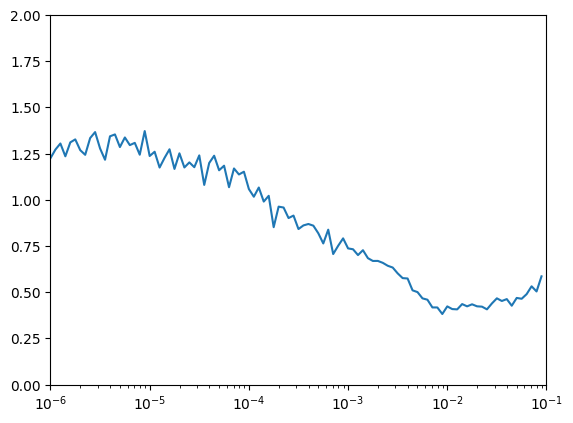

In [43]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 2])

In [44]:
def create_model():
    """
    Create and compile a model for binary classification.

    Returns:
        model: Compiled model for binary classification.
    """
    # Set the random seed for reproducibility
    tf.random.set_seed(42)
    
    # Create the model using the defined function
    model = create_uncompiled_model()

    learning_rate=1e-3
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=learning_rate),
                  metrics=["accuracy"])  

    return model

In [45]:
# Callback that used to save the model's weights during training.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_checkpoints', 
                                                   save_weights_only=True, 
                                                   save_best_only=True)

# Callback that used to monitor the validation loss during training
# and stop training if there is no improvement for a certain number of epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

epochs = 100

model = create_model()
history = model.fit(train_ds, epochs=epochs, 
                    validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
12/12 [==============================] - 2s 98ms/step - loss: 1.0270 - accuracy: 0.5212 - val_loss: 0.7083 - val_accuracy: 0.3252
Epoch 2/100
12/12 [==============================] - 1s 65ms/step - loss: 0.9720 - accuracy: 0.4868 - val_loss: 0.6515 - val_accuracy: 0.6748
Epoch 3/100
12/12 [==============================] - 1s 66ms/step - loss: 0.8135 - accuracy: 0.5767 - val_loss: 0.6340 - val_accuracy: 0.6748
Epoch 4/100
12/12 [==============================] - 1s 48ms/step - loss: 0.8723 - accuracy: 0.5132 - val_loss: 0.6276 - val_accuracy: 0.6748
Epoch 5/100
12/12 [==============================] - 1s 49ms/step - loss: 0.8649 - accuracy: 0.5159 - val_loss: 0.6263 - val_accuracy: 0.6748
Epoch 6/100
12/12 [==============================] - 1s 49ms/step - loss: 0.8138 - accuracy: 0.6164 - val_loss: 0.6255 - val_accuracy: 0.6748
Epoch 7/100
12/12 [==============================] - 1s 47ms/step - loss: 0.8064 - accuracy: 0.5529 - val_loss: 0.6250 - val_accuracy: 0.6748
Epoch 

12/12 [==============================] - 1s 60ms/step - loss: 0.3958 - accuracy: 0.8519 - val_loss: 0.3811 - val_accuracy: 0.8712
Epoch 59/100
12/12 [==============================] - 1s 50ms/step - loss: 0.4182 - accuracy: 0.8386 - val_loss: 0.3793 - val_accuracy: 0.8712
Epoch 60/100
12/12 [==============================] - 1s 51ms/step - loss: 0.4068 - accuracy: 0.8413 - val_loss: 0.3763 - val_accuracy: 0.8712
Epoch 61/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4202 - accuracy: 0.8466 - val_loss: 0.3774 - val_accuracy: 0.8712
Epoch 62/100
12/12 [==============================] - 0s 31ms/step - loss: 0.4248 - accuracy: 0.8466 - val_loss: 0.3769 - val_accuracy: 0.8712
Epoch 63/100
12/12 [==============================] - 1s 49ms/step - loss: 0.4087 - accuracy: 0.8333 - val_loss: 0.3760 - val_accuracy: 0.8773
Epoch 64/100
12/12 [==============================] - 0s 31ms/step - loss: 0.4016 - accuracy: 0.8545 - val_loss: 0.3760 - val_accuracy: 0.8712
Epoch 65/100

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cycle (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 weight_gain (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 hair_growth (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

 )                                                                                                
                                                                                                  
 normalization_3 (Normalization  (None, 1)           3           ['hip_in_cm[0][0]']              
 )                                                                                                
                                                                                                  
 normalization_4 (Normalization  (None, 1)           3           ['waist_in_cm[0][0]']            
 )                                                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 48)           0           ['category_encoding_1[0][0]',    
                                                                  'category_encoding_2[0][0]',    
          

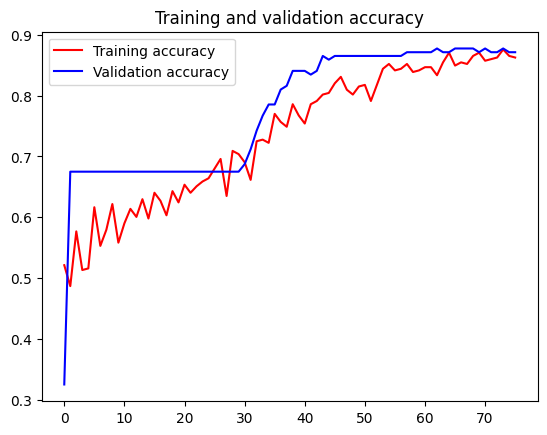

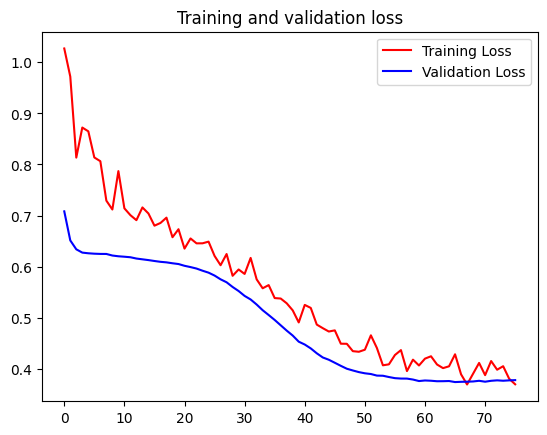

In [47]:
## Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
# Evaluates the trained model on the training dataset (train_ds)
loss, accuracy = model.evaluate(train_ds)
print("Accuracy", accuracy)

12/12 [==============================] - 0s 17ms/step - loss: 0.3477 - accuracy: 0.8836
Accuracy 0.8835979104042053


In [49]:
# Evaluates the trained model on the validation dataset (val_ds)
loss, accuracy = model.evaluate(val_ds)
print("Accuracy", accuracy)

6/6 [==============================] - 0s 17ms/step - loss: 0.3743 - accuracy: 0.8773
Accuracy 0.8773006200790405


In [50]:
# Reset states generated by Keras
# Uncomment this if you want to experiment with different model
# tf.keras.backend.clear_session()

In [51]:
model.save('keras_model')  # Save the model to the 'keras_model' file

INFO:tensorflow:Assets written to: keras_model\assets


In [52]:
# Save the model to the specified export directory
export_dir = 'saved_model/pcos-detection'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/pcos-detection\assets


In [53]:
# Select mode of optimization
mode = "Default" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [54]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
                                       tf.lite.OpsSet.SELECT_TF_OPS] # enable TensorFlow ops.

# Set the optimzations
converter.optimizations = [mode]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [55]:
# Define the file path and name for the TFLite model
tflite_model_file = pathlib.Path('./pcos-model.tflite')

# Write the TFLite model to the specified file
tflite_model_file.write_bytes(tflite_model)

48576

In [56]:
# Use saved_model_cli to show the details of the saved model
!saved_model_cli show --dir ./saved_model/pcos-detection --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['age'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_age:0
  inputs['bmi'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_bmi:0
  inputs['cycle'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_cycle:0
  inputs['fast_food'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_fast_food:0
  inputs['hair_growth'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_hair_growth:0
  inputs['hair_loss'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_hair_loss:0
  inputs['hip_in_cm'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_hip_in_cm:0
  inputs['pimples'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_pimples:0
  inputs['pulse_rate'

In [57]:
# Load the saved model from the export directory
loaded = tf.saved_model.load(export_dir)

# Print the keys of the loaded signatures
print(list(loaded.signatures.keys()))

# Access the "serving_default" signature and print the structured input signature
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)

# Print the structured outputs of the signature
print(infer.structured_outputs)

['serving_default']
((), {'hair_growth': TensorSpec(shape=(None, 1), dtype=tf.int64, name='hair_growth'), 'cycle': TensorSpec(shape=(None, 1), dtype=tf.int64, name='cycle'), 'hip_in_cm': TensorSpec(shape=(None, 1), dtype=tf.float32, name='hip_in_cm'), 'age': TensorSpec(shape=(None, 1), dtype=tf.int64, name='age'), 'skin_darkening': TensorSpec(shape=(None, 1), dtype=tf.int64, name='skin_darkening'), 'waist_in_cm': TensorSpec(shape=(None, 1), dtype=tf.float32, name='waist_in_cm'), 'pimples': TensorSpec(shape=(None, 1), dtype=tf.int64, name='pimples'), 'pulse_rate': TensorSpec(shape=(None, 1), dtype=tf.float32, name='pulse_rate'), 'fast_food': TensorSpec(shape=(None, 1), dtype=tf.int64, name='fast_food'), 'bmi': TensorSpec(shape=(None, 1), dtype=tf.float32, name='bmi'), 'weight_gain': TensorSpec(shape=(None, 1), dtype=tf.int64, name='weight_gain'), 'years_of_marriage': TensorSpec(shape=(None, 1), dtype=tf.float32, name='years_of_marriage'), 'hair_loss': TensorSpec(shape=(None, 1), dtype=t

In [58]:
# Create a zip archive of the "saved_model" directory
shutil.make_archive("pcos-savedmodel", "zip", "saved_model")

'H:\\Dokumen Dhika\\bangkit\\Capstone Project\\PCOS Detection\\pcos-savedmodel.zip'

In [59]:
# Define example input data
example_data = {
    'age': 23,
    'bmi': 24.5,
    'pulse_rate': 72,
    'years_of_marriage': 0,
    'hip': 80,
    'waist': 100,
    'cycle': 4,
    'weight_gain': 0,
    'hair_growth': 0,
    'skin_darkening': 0,
    'hair_loss': 0,
    'pimples': 0,
    'fast_food': 0,
}

# Create a TFLite interpreter and allocate tensors
interpreter = tf.lite.Interpreter(model_path='pcos-model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_data = {}
for name, value in example_data.items():
    if name == 'bmi':
        input_data[name] = tf.convert_to_tensor([[value]], dtype=tf.float32)  # We want the BMI input to accept decimals
    else:
        input_data[name] = tf.convert_to_tensor([[value]], dtype=tf.int64)

In [60]:
# Set input tensors in the interpreter
for input_name, input_tensor in input_data.items():
    input_details = interpreter.get_input_details()
    input_index = input_details[0]['index']
    input_dtype = input_details[0]['dtype']
    input_tensor = tf.cast(input_tensor, dtype=input_dtype)
    interpreter.set_tensor(input_index, input_tensor)

In [61]:
# Invoke the TFLite interpreter to perform inference
interpreter.invoke()

In [62]:
# Get the output tensor from the TFLite interpreter
output_data = interpreter.get_tensor(output_details[0]['index'])

In [63]:
# Make a prediction based on the output tensor and print the prediction
prediction = 0 if output_data[0][0] < 0.5 else 1
print("Prediction:", prediction)

Prediction: 0
